# NYC taxi trip duration prediction.

Importing the relevant modules and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from math import sin, cos, sqrt, atan2
import math
from sklearn.feature_selection import RFE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Loading the data into the data frame.

In [2]:
raw_data = pd.read_csv('nyc_taxi_trip_duration.csv')

Missing values

In [3]:
raw_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values in any of the coloumns

We will drop the id coloumn since it won't be useful in making predictions.

In [4]:
data_modified = raw_data.drop('id', axis=1)
data_modified.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

We will calculate the distance using the longitude and latitude columns. We will then extract the month,day of week and hour from the datetime cols.

In [5]:
def calc_distance(lon1,lat1,lon2,lat2):
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

In [6]:
data_modified['pickup_datetime'] = pd.to_datetime(data_modified['pickup_datetime'])
data_modified['month_name'] = data_modified['pickup_datetime'].apply(lambda x: x.month_name())
data_modified['day_of_week'] = data_modified['pickup_datetime'].dt.dayofweek
data_modified['pickup_hour'] = data_modified['pickup_datetime'].dt.hour
data_modified['distance'] = data_modified.apply(lambda x: calc_distance(x['pickup_longitude'],x['pickup_latitude'],x['dropoff_longitude'],x['dropoff_latitude']),axis=1)
data_modified

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month_name,day_of_week,pickup_hour,distance
0,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,February,0,16,80.142332
1,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,March,4,23,238.106427
2,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,February,6,17,462.455755
3,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,January,1,9,136.827598
4,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,February,2,6,274.888260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296,May,5,13,84.626211
729318,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315,February,0,0,45.924298
729319,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673,April,4,18,132.602309
729320,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447,June,6,9,55.948259


In [7]:
# Dropping the longitude and latitude values since we have already calculated the distance. 
# We will also drop pickup and dropoff datetime since we have already extracted the weekday, month and hour from the datetime cols.
data_modified = data_modified.drop(['pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude'], axis=1)
data_modified

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,month_name,day_of_week,pickup_hour,distance
0,2,1,N,400,February,0,16,80.142332
1,1,2,N,1100,March,4,23,238.106427
2,2,2,N,1635,February,6,17,462.455755
3,2,6,N,1141,January,1,9,136.827598
4,1,1,N,848,February,2,6,274.888260
...,...,...,...,...,...,...,...,...
729317,2,2,N,296,May,5,13,84.626211
729318,1,1,N,315,February,0,0,45.924298
729319,1,1,N,673,April,4,18,132.602309
729320,1,1,N,447,June,6,9,55.948259


In [8]:
data_modified['vendor_id'].value_counts()

vendor_id
2    390481
1    338841
Name: count, dtype: int64

In [9]:
data_modified['month_name'].value_counts()

month_name
March       128316
April       125634
May         124201
February    119364
June        117406
January     114401
Name: count, dtype: int64

In [10]:
data_modified['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    725282
Y      4040
Name: count, dtype: int64

In [11]:
data_modified['pickup_hour'].value_counts()

pickup_hour
18    45404
19    45262
20    42165
21    42045
22    40293
17    38313
14    37120
12    35820
15    35687
13    35630
23    35069
11    34061
9     33821
8     33612
10    32713
16    32147
7     27907
0     26726
1     19243
6     16552
2     13960
3     10424
4      7827
5      7521
Name: count, dtype: int64

Removing outliers from the distance coloumn since according to EDA, the distance coloumn contains the most number of outliers.

In [12]:
# Let's make a copy of the data frame
data_modified_no_outliers = data_modified.copy()

distance_stddev = data_modified['distance'].std()
distance_median = data_modified['distance'].median()
q1d = data_modified['distance'].quantile(0.25)
q3d = data_modified['distance'].quantile(0.75)
whisker1d = q1d - (distance_stddev * 1.5)
whisker2d = q3d + (distance_stddev * 1.5)
# data_modified_no_outliers = data_modified[data_modified['distance'] < whisker2]

# Let's also remove those values of distance for which the speed is higher than the third whisker.

data_modified['speed'] = data_modified['distance']/data_modified['trip_duration']
speed_stddev = data_modified['speed'].std()
speed_median = data_modified['speed'].median()
q1s = data_modified['speed'].quantile(0.25)
q3s = data_modified['speed'].quantile(0.75)
whisker1s = q1s - (speed_stddev * 1.5)
whisker2s = q3s + (speed_stddev * 1.5)

data_modified_no_outliers = data_modified_no_outliers[(data_modified['speed'] < min(whisker2s,whisker2d))] 
data_modified.drop('speed', axis=1, inplace=True)
data_modified_no_outliers

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,month_name,day_of_week,pickup_hour,distance
0,2,1,N,400,February,0,16,80.142332
1,1,2,N,1100,March,4,23,238.106427
2,2,2,N,1635,February,6,17,462.455755
3,2,6,N,1141,January,1,9,136.827598
4,1,1,N,848,February,2,6,274.888260
...,...,...,...,...,...,...,...,...
729317,2,2,N,296,May,5,13,84.626211
729318,1,1,N,315,February,0,0,45.924298
729319,1,1,N,673,April,4,18,132.602309
729320,1,1,N,447,June,6,9,55.948259


The new data frame has 678404 rows since we have removed all data points beyond the second whisker from the distance coloumn.

Let's convert the pickup hour column into bins. Our bins will be morning, afternoon, evening, night and mid-night.

In [13]:
data_modified_no_outliers.loc[:,'pickup_hour'] = data_modified_no_outliers.pickup_hour.astype('int64')
data_modified_no_outliers.dtypes                                                                                    

vendor_id               int64
passenger_count         int64
store_and_fwd_flag     object
trip_duration           int64
month_name             object
day_of_week             int32
pickup_hour             int64
distance              float64
dtype: object

In [14]:
data_modified_no_outliers.loc[:,'pickup_hour'] = data_modified_no_outliers['pickup_hour'].map({5:'Morning', 6:'Morning',7:'Morning', 8:'Morning', 9:'Morning', 10:'Morning', 
                                             11:'Morning',
                                             12:'Afternoon', 13:'Afternoon', 14:'Afternoon', 15:'Afternoon', 16:'Afternoon',
                                             17:'Evening', 18:'Evening', 19:'Evening', 20:'Evening',
                                             21:'Night', 22:'Night', 23:'Night',
                                             0:'Mid-Night', 1:'Mid-Night', 2:'Mid-Night', 3:'Mid-Night', 4:'Mid-Night'})
data_modified_no_outliers

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,month_name,day_of_week,pickup_hour,distance
0,2,1,N,400,February,0,Afternoon,80.142332
1,1,2,N,1100,March,4,Night,238.106427
2,2,2,N,1635,February,6,Evening,462.455755
3,2,6,N,1141,January,1,Morning,136.827598
4,1,1,N,848,February,2,Morning,274.888260
...,...,...,...,...,...,...,...,...
729317,2,2,N,296,May,5,Afternoon,84.626211
729318,1,1,N,315,February,0,Mid-Night,45.924298
729319,1,1,N,673,April,4,Evening,132.602309
729320,1,1,N,447,June,6,Morning,55.948259


Let's convert these categorical columns to one hot encoded values

In [15]:
data_one_hot_encoded = pd.concat([data_modified_no_outliers,pd.get_dummies(data_modified_no_outliers['vendor_id'],drop_first=True, prefix = str('vendor_id'),prefix_sep='_'),
                                 pd.get_dummies(data_modified_no_outliers['store_and_fwd_flag'],drop_first=True, prefix = str('store_and_fwd_flag'),prefix_sep='_'),
                                 pd.get_dummies(data_modified_no_outliers['month_name'],drop_first=True, prefix = str('month_name'),prefix_sep='_'),
                                 pd.get_dummies(data_modified_no_outliers['day_of_week'],drop_first=True, prefix = str('day_of_week'),prefix_sep='_'),
                                 pd.get_dummies(data_modified_no_outliers['pickup_hour'],drop_first=True, prefix = str('pickup_hour'),prefix_sep='_')],
                                 axis=1)
data_one_hot_encoded

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,month_name,day_of_week,pickup_hour,distance,vendor_id_2,store_and_fwd_flag_Y,...,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,pickup_hour_Evening,pickup_hour_Mid-Night,pickup_hour_Morning,pickup_hour_Night
0,2,1,N,400,February,0,Afternoon,80.142332,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1,2,N,1100,March,4,Night,238.106427,False,False,...,False,False,False,True,False,False,False,False,False,True
2,2,2,N,1635,February,6,Evening,462.455755,True,False,...,False,False,False,False,False,True,True,False,False,False
3,2,6,N,1141,January,1,Morning,136.827598,True,False,...,True,False,False,False,False,False,False,False,True,False
4,1,1,N,848,February,2,Morning,274.888260,False,False,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,2,2,N,296,May,5,Afternoon,84.626211,True,False,...,False,False,False,False,True,False,False,False,False,False
729318,1,1,N,315,February,0,Mid-Night,45.924298,False,False,...,False,False,False,False,False,False,False,True,False,False
729319,1,1,N,673,April,4,Evening,132.602309,False,False,...,False,False,False,True,False,False,True,False,False,False
729320,1,1,N,447,June,6,Morning,55.948259,False,False,...,False,False,False,False,False,True,False,False,True,False


Dropping the categorical columns

In [16]:
data_one_hot_encoded = data_one_hot_encoded.drop(['vendor_id', 'store_and_fwd_flag', 'month_name', 'day_of_week','pickup_hour'],axis=1)

In [17]:
data_one_hot_encoded

,passenger_count,trip_duration,distance,vendor_id_2,store_and_fwd_flag_Y,month_name_February,month_name_January,month_name_June,month_name_March,month_name_May,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,pickup_hour_Evening,pickup_hour_Mid-Night,pickup_hour_Morning,pickup_hour_Night
0,1,400,80.142332,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,1100,238.106427,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True
2,2,1635,462.455755,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False
3,6,1141,136.827598,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False
4,1,848,274.888260,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,2,296,84.626211,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False
729318,1,315,45.924298,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
729319,1,673,132.602309,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
729320,1,447,55.948259,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False


Let's convert the true and false values to 1s and 0s so that we can feed them in the algorithm.

In [18]:
for i in range(3,len(data_one_hot_encoded.columns)):
    data_one_hot_encoded.iloc[:,i] = data_one_hot_encoded.iloc[:,i].map({True:1,False:0})
data_one_hot_encoded

,passenger_count,trip_duration,distance,vendor_id_2,store_and_fwd_flag_Y,month_name_February,month_name_January,month_name_June,month_name_March,month_name_May,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,pickup_hour_Evening,pickup_hour_Mid-Night,pickup_hour_Morning,pickup_hour_Night
0,1,400,80.142332,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1100,238.106427,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
2,2,1635,462.455755,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,6,1141,136.827598,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,848,274.888260,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,2,296,84.626211,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
729318,1,315,45.924298,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
729319,1,673,132.602309,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
729320,1,447,55.948259,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


Let's apply log transformation to the distance and trip_duration coloumns.

In [19]:
data_one_hot_encoded['trip_duration'] = np.log(1+data_one_hot_encoded['trip_duration'])
data_one_hot_encoded['distance'] = np.log(1+data_one_hot_encoded['distance'])
data_one_hot_encoded

,passenger_count,trip_duration,distance,vendor_id_2,store_and_fwd_flag_Y,month_name_February,month_name_January,month_name_June,month_name_March,month_name_May,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,pickup_hour_Evening,pickup_hour_Mid-Night,pickup_hour_Morning,pickup_hour_Night
0,1,5.993961,4.396205,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,7.003974,5.476909,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
2,2,7.400010,6.138711,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,6,7.040536,4.926004,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,6.744059,5.619996,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,2,5.693732,4.449991,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
729318,1,5.755742,3.848536,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
729319,1,6.513230,4.894868,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
729320,1,6.104793,4.042143,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [20]:
data_one_hot_encoded.columns.values

array(['passenger_count', 'trip_duration', 'distance', 'vendor_id_2',
       'store_and_fwd_flag_Y', 'month_name_February',
       'month_name_January', 'month_name_June', 'month_name_March',
       'month_name_May', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'pickup_hour_Evening', 'pickup_hour_Mid-Night',
       'pickup_hour_Morning', 'pickup_hour_Night'], dtype=object)

In [21]:
input_cols = ['passenger_count', 'distance',
                             'vendor_id_2', 'store_and_fwd_flag_Y', 'month_name_February',
                             'month_name_January', 'month_name_June', 'month_name_March',
                             'month_name_May', 'day_of_week_1', 'day_of_week_2',
                             'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
                             'pickup_hour_Evening', 'pickup_hour_Mid-Night',
                             'pickup_hour_Morning', 'pickup_hour_Night']
modified_inputs = data_one_hot_encoded[input_cols]
modified_targets_log = data_one_hot_encoded[['trip_duration']]

In [22]:
xtrain, xtest, ytrain, ytest = train_test_split(modified_inputs, modified_targets_log, test_size=0.2, random_state=42)

Creating a model for all of the features

In [23]:
model = LinearRegression()
model.fit(xtrain,ytrain)
predictions = model.predict(xtest)

In [24]:
model.coef_

array([[ 0.00647046,  0.65221241,  0.02049786,  0.02693854, -0.03701307,
        -0.04504281,  0.02088739, -0.03700777,  0.01745547,  0.08690514,
         0.11142718,  0.11785633,  0.10081906,  0.02378277, -0.06169618,
        -0.09561298, -0.28253888, -0.1247737 , -0.21345542]])

Plotting all of the coefficients

Text(0.5, 1.0, 'Normalized Coefficient plot')

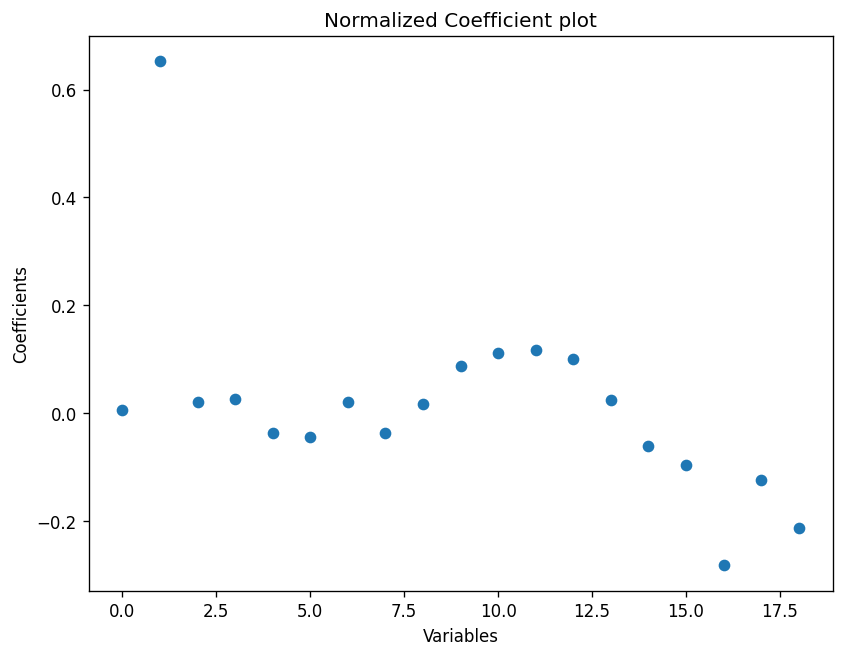

In [25]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(xtrain.columns))
y = model.coef_
plt.scatter(x,y)
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Normalized Coefficient plot')

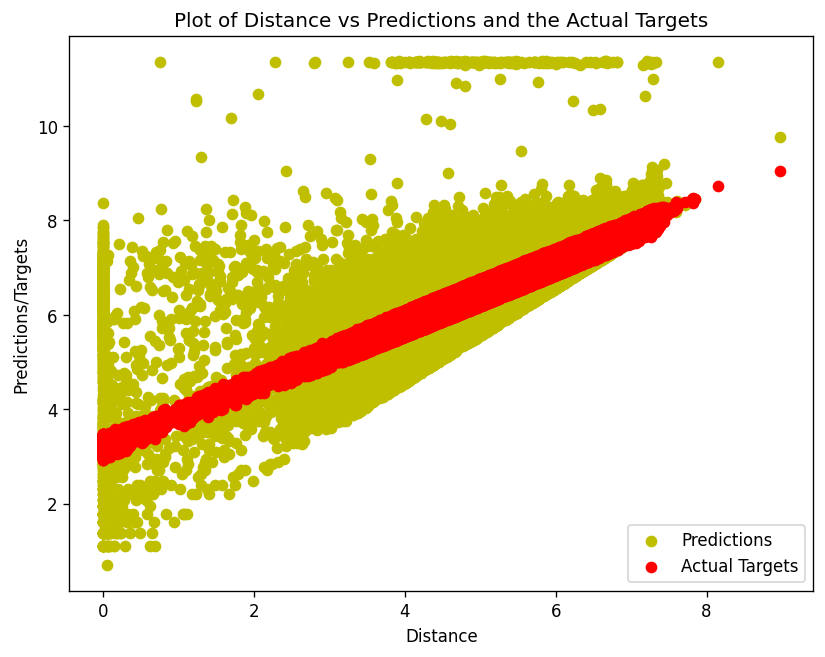

In [26]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = xtest['distance']
y1 = ytest
y2 = predictions
plt.scatter(x,y1,c='y')
plt.scatter(x,y2,c='r')
plt.legend(['Predictions', 'Actual Targets'])
plt.xlabel( "Distance")
plt.ylabel('Predictions/Targets')
plt.title('Plot of Distance vs Predictions and the Actual Targets')
plt.show()

It can be seen that distance is the biggest factor in deciding the trip duration and all other factors have a minor effect on the output.

In [27]:
r2 = model.score(xtest,ytest)
r2

0.5999611437553253

The r2 score is approximately 60% for the model. This is not very good but it's decent.

In [28]:
k = len(xtest.columns.values)
n = len(ytest['trip_duration'])
n,k

(140241, 19)

In [29]:
adjusted_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))
adjusted_r2

0.5999069383348201

The adjusted R2 value of the model is also similar. Our model explains a decent amount of variation in the data.

In [30]:
mse = mean_squared_error(ytest,predictions)
rmse= math.sqrt(mse)
rmse

0.49480979346338244

Mean square error is slightly high.

Performing K fold cross validation. K = 10

In [31]:
from sklearn.model_selection import cross_val_score
score_array = cross_val_score(LinearRegression() , X = xtrain, y = ytrain, cv = 10)
mean_score = score_array.mean()
print("Cross validation scores:", score_array)
print("Mean of cross validation score:", mean_score)

Cross validation scores: [0.60215091 0.60892796 0.60475249 0.60197819 0.60073469 0.5948049
 0.59408284 0.61004943 0.6151823  0.60752369]
Mean of cross validation score: 0.6040187399573616


Cross validation score for all iterations is approximately the same (0.60).

# Reverse Feature Elimination (RFE) 

Let's find the top 10 features which contribute most to the output.

In [32]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1, step=1)
rfe.fit(modified_inputs, modified_targets_log)
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = modified_inputs.columns
ranking_df['Rank'] = rfe.ranking_
ranked = ranking_df.sort_values(by=['Rank'])
ranked

,Feature_name,Rank
1,distance,1
16,pickup_hour_Mid-Night,2
18,pickup_hour_Night,3
11,day_of_week_3,4
10,day_of_week_2,5
12,day_of_week_4,6
9,day_of_week_1,7
17,pickup_hour_Morning,8
15,pickup_hour_Evening,9
14,day_of_week_6,10


It can be seen that distance has the highest rank and passenger_count comes at the end.

In [33]:
score_array = cross_val_score(LinearRegression() , X = xtrain[ranked['Feature_name'][:10]], y = ytrain, cv = 10)
mean_score = score_array.mean()
print("Cross validation scores:", score_array)
print("Mean of cross validation score:", mean_score)

Cross validation scores: [0.60054449 0.60735036 0.60314809 0.60045485 0.59894312 0.59297924
 0.59265187 0.60858453 0.61367845 0.60580285]
Mean of cross validation score: 0.6024137829798992


We can see that the cross vallidation score has improved marginally after taking only the top ranking features. 

## Overall our model has a score of approximately 60%. This is not very good but the accuracy can be increased with better models.